In [1]:
# imports
import cv2
import math
import matplotlib.pyplot as plt

# constants
light_threshold = 127
light_cutoff = 16
saturation_threshold = 50
saturation_weight = 9
snap_range = 32

In [2]:
def generateMockMask(mask_path):
    img = cv2.imread(mask_path)
    img_tmp = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img_tmp[:,:,2] > 250

In [3]:
# calculate average lightness of an hls image
def getAverageLightness(img_hls, mask):
    l_channel = img_hls[:,:,1]
    return l_channel[mask].sum() / mask.sum()

def isGrayscale(saturation, light):
    if saturation < saturation_threshold:
        return True
    if light < light_cutoff or light > (255 - light_cutoff):
        return True
    return False

# take an rgb image and convert it to dark mode
def emulateDarkMode(img_rgb, mask):
    img_tmp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    for x in range(img_tmp.shape[0]):
        for y in range(img_tmp.shape[1]):
            if mask[x][y]:
                sat_val = img_tmp[x][y][2]
                old_val = img_tmp[x][y][1]
                dark_val = 255 if old_val == 0 else min(255, 1000000 / math.pow(old_val, 2))

                # if saturation is abolve a certain level, boost the value to avoid dimming
                if not isGrayscale(sat_val, old_val):
                    dark_val = (dark_val + (old_val * saturation_weight)) / (2 + saturation_weight)

                img_tmp[x][y][1] = dark_val

    return cv2.cvtColor(img_tmp, cv2.COLOR_HLS2RGB)

# take a generally dark image and go more extreme
def improveContrast(img_rgb, mask):
    img_tmp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)
    for x in range(img_tmp.shape[0]):
        for y in range(img_tmp.shape[1]):
            if mask[x][y]:
                sat_val = img_tmp[x][y][2]
                old_val = img_tmp[x][y][1]

                # if saturation low, snap the colors to white or black
                if isGrayscale(sat_val, old_val):
                    img_tmp[x][y][1] = 208 / (1 + (math.pow(math.e, (40 - old_val) / 4)))

    return cv2.cvtColor(img_tmp, cv2.COLOR_HLS2RGB)

# combined function
def emulateDarkModeWithContrast(img_rgb, mask):
    img_tmp = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)

    # check avg lightness
    avg_light = getAverageLightness(img_tmp, mask)

    for x in range(img_tmp.shape[0]):
        for y in range(img_tmp.shape[1]):
            if mask[x][y]:
                sat_val = img_tmp[x][y][2]
                old_val = img_tmp[x][y][1]

                # if dealing with light image, emulate dark mode
                if avg_light > light_threshold:
                    dark_val = 255 if old_val == 0 else min(255, 1000000 / math.pow(old_val, 2))
                    # if saturation is abolve a certain level, boost the value to avoid dimming
                    if not isGrayscale(sat_val, old_val):
                        dark_val = (dark_val + (old_val * saturation_weight)) / (2 + saturation_weight)

                # if saturation low, snap the colors to white or black
                if isGrayscale(sat_val, old_val):
                    dark_val = 208 / (1 + (math.pow(math.e, (40 - dark_val) / 4)))

                img_tmp[x][y][1] = dark_val

    return cv2.cvtColor(img_tmp, cv2.COLOR_HLS2RGB)

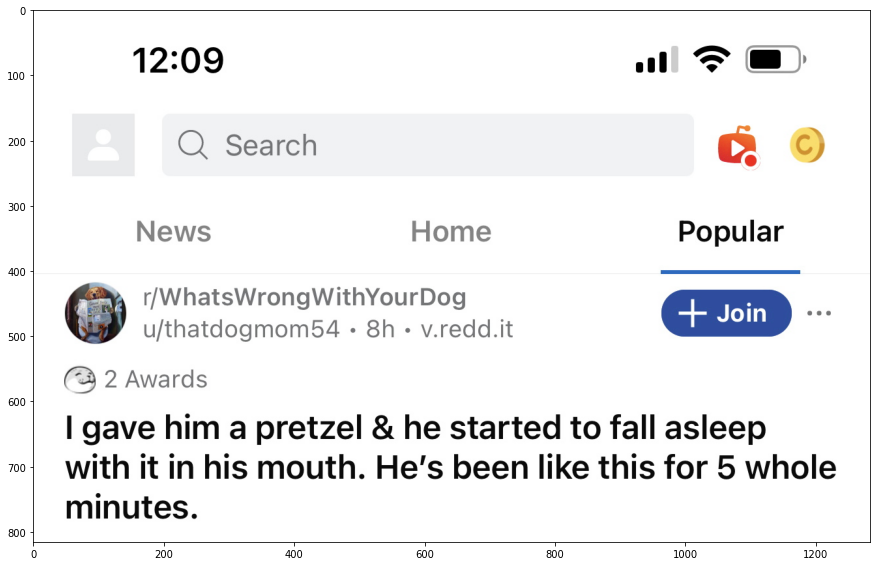

In [4]:
path = './screens/seg02_reddit-header.jpg'
img = cv2.imread(path)
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.figure(figsize = (15, 15))
img_rgb = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
plt.imshow(img_rgb)

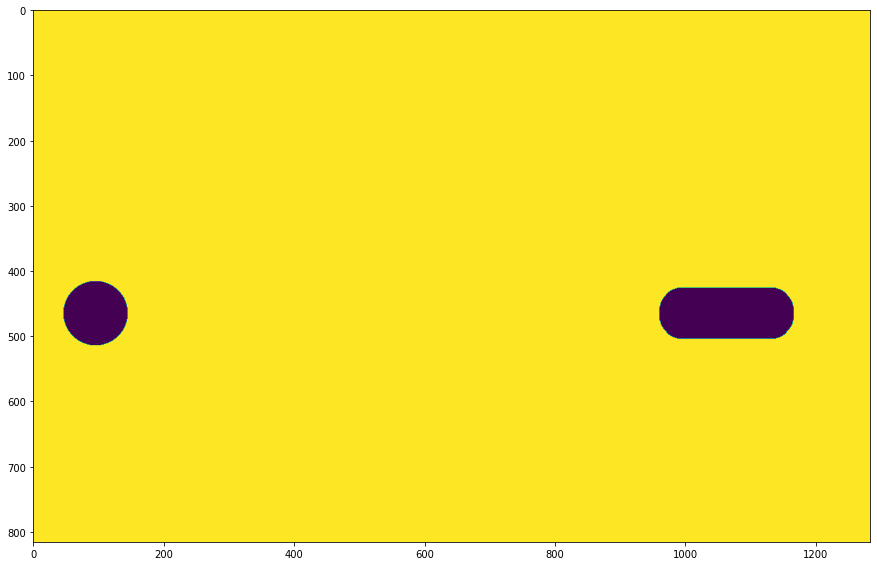

In [5]:
mask = generateMockMask('./screens/mask02_reddit-header.jpg')
plt.figure(figsize = (15, 15))
plt.imshow(mask)

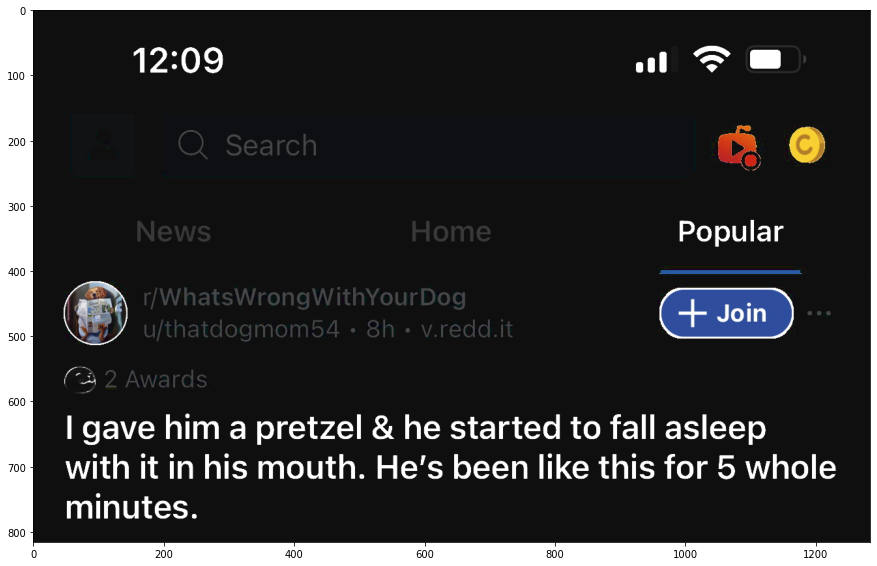

In [6]:
plt.figure(figsize = (15, 15))
img_dark = emulateDarkMode(img_rgb, mask)
plt.imshow(img_dark)

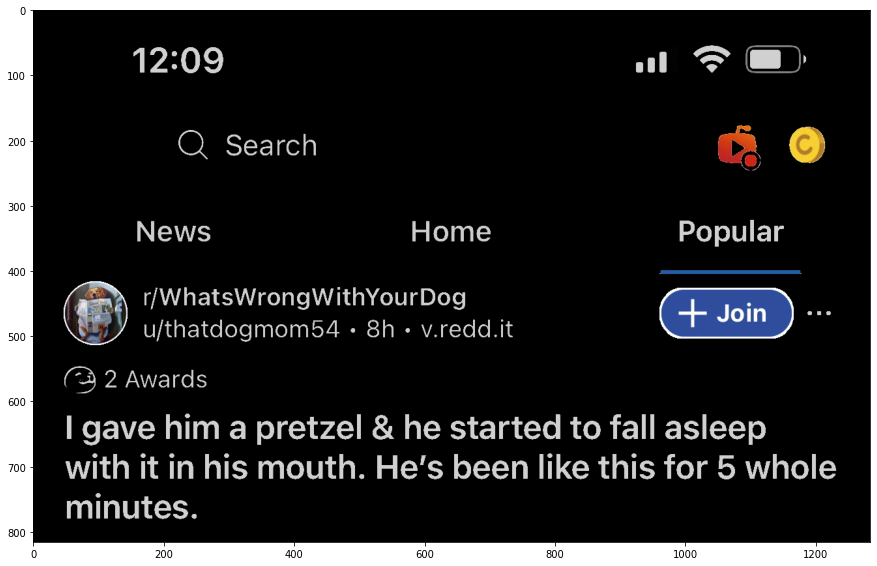

In [7]:
plt.figure(figsize = (15, 15))
img_exdark = improveContrast(img_dark, mask)
plt.imshow(img_exdark)


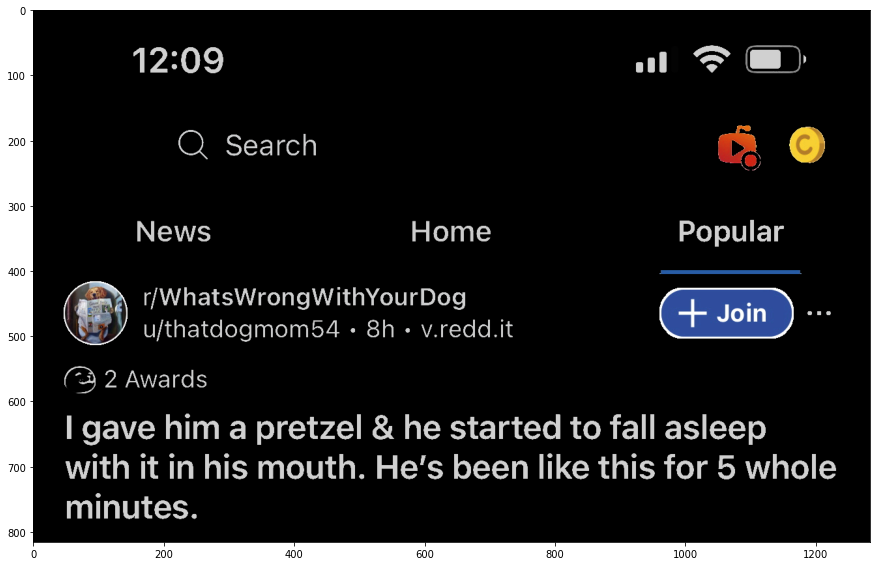

In [8]:
plt.figure(figsize = (15, 15))
img_out = emulateDarkModeWithContrast(img_rgb, mask)
plt.imshow(img_out)